In [10]:
import json
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
# load loss files
loss_files = glob('./losses/*.json')

toy_losses = []
mnist_losses = []
for lf in loss_files:
    if 'mnist' in lf:
        mnist_losses.append(lf)
    else:
        toy_losses.append(lf)
print(mnist_losses)
print(toy_losses)

['./losses\\draw_mnist_10.json', './losses\\lvae_mnist_10.json', './losses\\vae_mnist_10.json']
['./losses\\flow_8gaussians_10.json', './losses\\flow_checkerboard_10.json', './losses\\lvae_8gaussians_10.json', './losses\\vae_8gaussians_10.json', './losses\\vae_checkerboard_10.json']


In [124]:
def compute_params(loss):
    N = loss.shape[0]
    min_, max_, last = [], [], []
    
    # first, exceeds = [], []
    for i in range(N):
        # remove nans from test loss
        tll = loss[i]
        tll = np.abs(tll[~np.isnan(tll)])

        if len(tll):
            min_.append(tll.min())
            max_.append(tll.max())
            last.append(tll[-1])

            # first_ = tll[:10].mean()
            # first.append(first_)
            # exceeds.append(np.sum(first_ > tll))
    min_ = np.array(min_)
    max_ = np.array(max_)
    last = np.array(last)
    # first = np.array(first)
    # exceeds = np.array(exceeds)

    # store parameters
    params = [
        min_.mean(),
        max_.mean(),
        last.mean(),
        # first.mean(),
        # exceeds.mean()
    ]
    return params

In [138]:
# plotting options
xlabels = ['min', 'max', 'last'] #, 'first', 'exceeds'
xs = np.arange(len(xlabels))

## Inspect Convergence on Toy Data

In [139]:
metrics_gauss = {}
metrics_check = {}
for tl in toy_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    #
    test_loss = np.array(losses['val'])
    params = compute_params(test_loss)
    if dataname =='8gaussians':
        metrics_gauss[model] = params
    elif dataname == 'checkerboard':
        metrics_check[model] = params

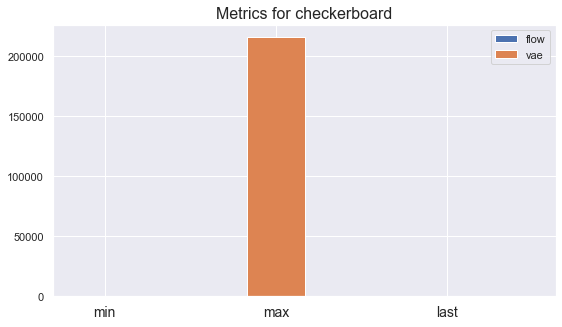

In [155]:
# for checkerboard
plt.figure(figsize=(9, 5))
width = 1/(len(metrics_check) + 1)
for i, model in enumerate(metrics_check):
    params = metrics_check[model]
    plt.bar(xs-width*(i-1), params, width=width, label=model)
plt.title('Metrics for checkerboard', fontsize=16)
plt.xticks(xs, xlabels, fontsize=14)
plt.legend()
plt.show()

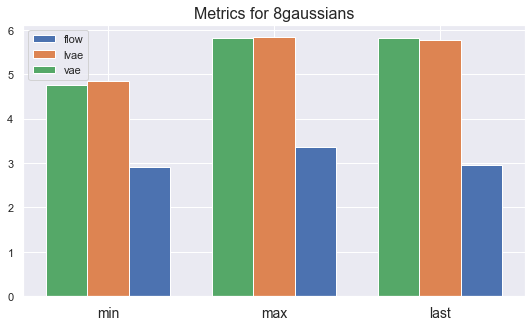

In [156]:
# for 8gaussians
plt.figure(figsize=(9, 5))
width = 1/(len(metrics_gauss) + 1)
for i, model in enumerate(metrics_gauss):
    params = metrics_gauss[model]
    plt.bar(xs-width*(i-1), params, width=width, label=model)
plt.title('Metrics for 8gaussians', fontsize=16)
plt.xticks(xs, xlabels, fontsize=14)
plt.legend()
plt.show()

## Inspect Convergence on MNIST 

In [157]:
metrics_mnist = {}
for tl in mnist_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    #
    test_loss = np.array(losses['val'])
    params = compute_params(test_loss)
    metrics_mnist[model] = compute_params(test_loss)

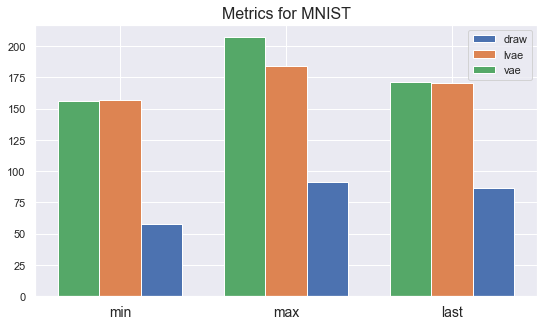

In [158]:
# for mnist
plt.figure(figsize=(9, 5))
width = 1/(len(metrics_mnist) + 1)
for i, model in enumerate(metrics_mnist):
    params = metrics_mnist[model]
    plt.bar(xs-width*(i-1), params, width=width, label=model)
plt.title('Metrics for MNIST', fontsize=16)
plt.xticks(xs, xlabels, fontsize=14)
plt.legend()
plt.show()